In [ ]:
%matplotlib inline

from ood_metrics import plot_roc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm, trange
import numpy as np
import sklearn.covariance


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc=str(epoch)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, total=len(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    tqdm.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# Training settings
batch_size = 128
test_batch_size = 1000
epochs = 10
lr = 0.01
momentum = 0.5
no_cuda = False
seed = 1
log_interval = 10
save_model = False
num_classes = 10

use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
data_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

fashion_train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('/media/tadenoud/DATADisk/datasets/', train=True, transform=data_transform),
    batch_size=batch_size, shuffle=True, **kwargs)

fashion_test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('/media/tadenoud/DATADisk/datasets/', train=False, transform=data_transform),
    batch_size=test_batch_size, shuffle=False, **kwargs)

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tadenoud/DATADisk/datasets/', train=True, transform=data_transform),
    batch_size=batch_size, shuffle=True, **kwargs)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tadenoud/DATADisk/datasets/', train=False, transform=data_transform),
    batch_size=test_batch_size, shuffle=False, **kwargs)

letters_train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('/media/tadenoud/DATADisk/datasets/', train=True, split='letters', transform=data_transform),
    batch_size=test_batch_size, shuffle=True, **kwargs)

letters_test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('/media/tadenoud/DATADisk/datasets/', train=False, split='letters', transform=data_transform),
    batch_size=test_batch_size, shuffle=False, **kwargs)


train_loader = fashion_train_loader
id_test_loader = fashion_test_loader
ood_test_loader = mnist_test_loader

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, id_test_loader)

if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

In [ ]:
# Extract mahalanobis features
def penultimate_forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    penultimate = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(penultimate))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1), penultimate


def bind_method(obj, method):
    """Bind new methods to already instantiated objects."""
    setattr(obj, method.__name__, method.__get__(obj))

    
def extract_features(model, device, train_loader):
    model.eval()
    
    outputs, features, labels = [], [], []
    
    with torch.no_grad():
        for data, target in tqdm(train_loader, total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            outs, feats = model.penultimate_forward(data)
       
            labels.append(target.detach().cpu().numpy())
            features.append(feats.detach().cpu().numpy())
            outputs.append(outs.detach().cpu().numpy())
            
    return np.concatenate(outputs), np.concatenate(features), np.concatenate(labels)


def estimate_mahalanobis_parameters(features, labels, return_tensor=False):
    class_means = []
    centered_features = features.copy()

    for i in range(num_classes):
        mask = labels == i

        # Calculate the class mean
        class_means.append(features[mask].mean(axis=0))

        # Create mean subtracted features for covariance estimation
        centered_features[mask] -= class_means[i]


    # Calculate the inverted covariance matrix
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    group_lasso.fit(centered_features)
    precision = group_lasso.precision_
    covariance = group_lasso.covariance_
    
    if return_tensor:
        class_means = torch.from_numpy(np.array(class_means)).float().cuda()
        precision = torch.from_numpy(precision).float().cuda()
        covariance = torch.from_numpy(covariance).float().cuda()
    
    return class_means, precision, covariance

In [ ]:
bind_method(model, penultimate_forward)
outputs1, features1, labels1 = extract_features(model, device, train_loader)
class_means1, precision1, _ = estimate_mahalanobis_parameters(features1, labels1, return_tensor=True)

In [ ]:
def get_max_softmax_scores(model, device, id_loader, ood_loader):
    """Get the max softmax output for all data in id_loader and ood_loader."""
    model.eval()
    max_softmax = []
    labels = []
    
    with torch.no_grad():
        for data, target in tqdm(id_loader, total=len(id_loader)):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            max_softmax.append(outputs.detach().cpu().numpy())
            labels.append(target.detach().cpu().numpy())
            
        for data, target in tqdm(ood_loader, total=len(ood_loader)):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            max_softmax.append(outputs.detach().cpu().numpy())
            labels.append(np.ones(len(target)) * -1)
            
    return np.concatenate(max_softmax).max(axis=1), np.concatenate(labels)


def mahalanobis_distance(features, means, inv_mahal_cov, device):   
    """Return a matrix with dist to each mean for each feature in the features batch."""
    # Tile the features and means to vectorize the operation
    num_means = means.shape[0]
    num_feats = features.shape[0]

    features = features.repeat(1, num_means).view(-1, features.shape[1])

    # subtract means in batches
    x = features - means.repeat(num_feats, 1)

    # matmul, take diagonal, then reshape
    dists = x.mm(inv_mahal_cov).mm(x.transpose(0,1)).diag()
    dists = dists.view(num_feats, num_means).transpose(0,1)

    min_dists, labels = dists.min(dim=0)
    return labels, min_dists


def test_mahalanobis_classification(model, class_means, precision, device, test_loader):
    """Test the classification accuracy using MD as the classifier."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, total=len(test_loader)):
            data, target = data.to(device), target.to(device)
            _, features = model.penultimate_forward(data)
            pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
            
            correct += pred.eq(target.view_as(pred)).sum().item()

    tqdm.write('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
def get_mahalanobis_distances(model, class_means, precision, device, id_loader, ood_loader):
    """Get the distance to the nearest class_mean and return that distance and the class label for
        all data in the id_loader and ood_loader."""
    model.eval()
    min_dists = []
    labels = []
    
    with torch.no_grad():
        for data, target in tqdm(id_loader, total=len(id_loader)):
            data, target = data.to(device), target.to(device)
            _, features = model.penultimate_forward(data)
            pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
            min_dists.append(min_dist.detach().cpu().numpy())
            labels.append(target.detach().cpu().numpy())
            
        for data, target in tqdm(ood_loader, total=len(ood_loader)):
            data, target = data.to(device), target.to(device)
            _, features = model.penultimate_forward(data)
            pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
            min_dists.append(min_dist.detach().cpu().numpy())
            labels.append(np.ones(len(target)) * -1)
            
    return np.concatenate(min_dists), np.concatenate(labels)


def get_mahalanobis_input_perturbation_distances(model, class_means, precision, device, id_loader, ood_loader, epsilon):
    """Get the distance to the nearest class_mean and return that distance and the class label for
        all data in the id_loader and ood_loader."""
    model.eval()
    min_dists = []
    labels = []
    model.train()
    
    for data, target in tqdm(id_loader, total=len(id_loader)):
        data, target = data.to(device), target.to(device)
        data.requires_grad_()
        
        # First pass
        _, features = model.penultimate_forward(data)
        pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
        
        # Input perturbation
        min_dist = torch.mean(min_dist, dim=0).backward()
        data = data - torch.sign(data.grad) * epsilon 
        
        # Second pass
        _, features = model.penultimate_forward(data)
        pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
        
        min_dists.append(min_dist.detach().cpu().numpy())
        labels.append(target.detach().cpu().numpy())

        
    for data, target in tqdm(ood_loader, total=len(ood_loader)):
        data, target = data.to(device), target.to(device)
        data.requires_grad_()
        
        # First pass
        _, features = model.penultimate_forward(data)
        pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
        
        # Input perturbation
        min_dist = torch.mean(min_dist, dim=0).backward()
        data = data - torch.sign(data.grad) * epsilon 
        
        # Second pass
        _, features = model.penultimate_forward(data)
        pred, min_dist = mahalanobis_distance(features, class_means, precision, device)
        
        min_dists.append(min_dist.detach().cpu().numpy())
        labels.append(np.ones(len(target)) * -1)

    return np.concatenate(min_dists), np.concatenate(labels)

In [10]:
# Features for Vahdat

_, features, labels = extract_features(model, device, fashion_train_loader)


import h5py as h5
with h5.File("fashion_mnist_train_features.h5", "a") as f:
    f.create_dataset("features", data=features)
    f.create_dataset("labels", data=labels)    

In [12]:
# Features for Vahdat

_, features, labels = extract_features(model, device, fashion_test_loader)

import h5py as h5
with h5.File("fashion_mnist_val_features.h5", "a") as f:
    f.create_dataset("features", data=features)
    f.create_dataset("labels", data=labels)    

In [13]:
scores1, labels1 = get_mahalanobis_input_perturbation_distances(model, class_means1, precision1, device, 
                                           id_test_loader, ood_test_loader, epsilon=0.1)

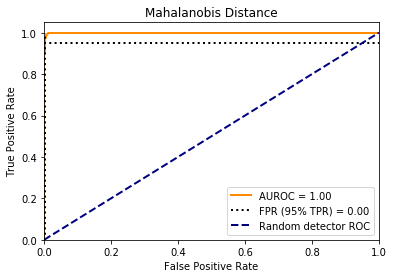

In [14]:
temp_labels1 = labels1.copy()
temp_labels1[temp_labels1 >= 0] = 0
temp_labels1[temp_labels1 < 0] = 1

plot_roc(scores1, temp_labels1, title="Mahalanobis Distance")

In [15]:
test_mahalanobis_classification(model, class_means1, precision1, device, id_test_loader)



Test set: Accuracy: 8729/10000 (87%)



In [16]:
scores1, labels1 = get_mahalanobis_distances(model, class_means1, precision1, device, 
                                           id_test_loader, ood_test_loader)

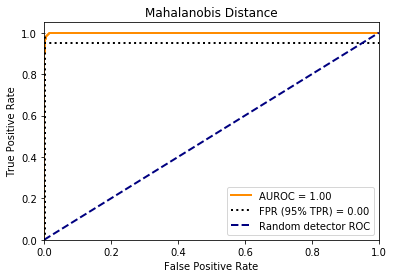

In [17]:
temp_labels1 = labels1.copy()
temp_labels1[temp_labels1 >= 0] = 0
temp_labels1[temp_labels1 < 0] = 1

plot_roc(scores1, temp_labels1, title="Mahalanobis Distance")

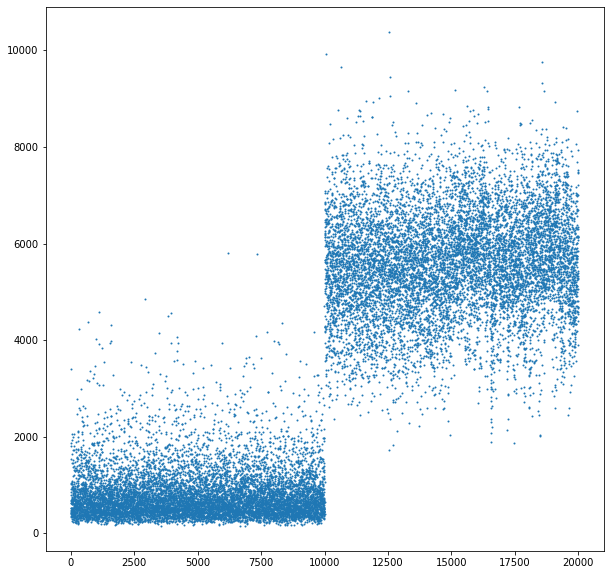

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(range(len(scores1)), scores1, s=1)
plt.show()

In [23]:
from ood_metrics import calc_metrics

calc_metrics(scores1, temp_labels1)

{'fpr_at_95_tpr': 0.9889,
 'detection_error': 0.5,
 'auroc': 0.30270156499999995,
 'aupr_in': 0.38586147613473276,
 'aupr_out': 0.38268010783074263}

In [24]:
scores1, labels1 = get_max_softmax_scores(model, device, id_test_loader, ood_test_loader)

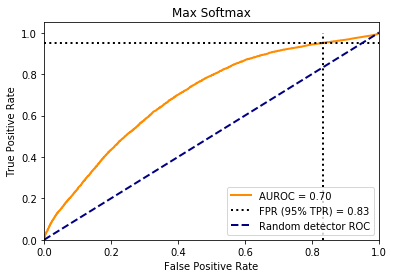

In [25]:
temp_labels1 = labels1.copy()
temp_labels1[temp_labels1 >= 0] = 0
temp_labels1[temp_labels1 < 0] = 1

plot_roc(-scores1, temp_labels1, title="Max Softmax")

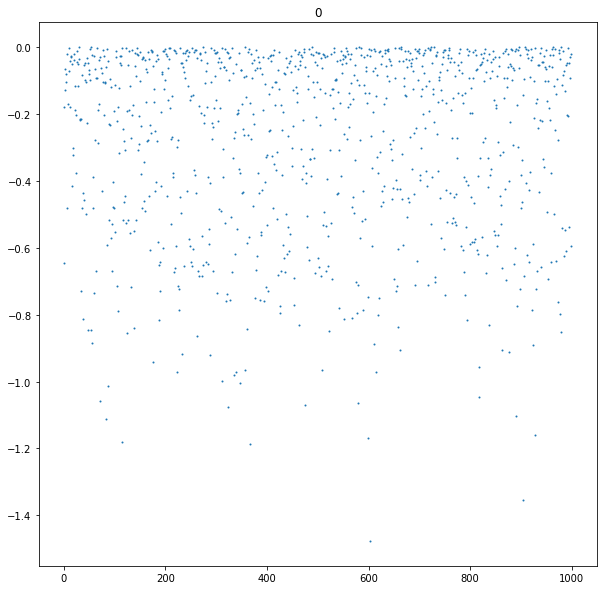

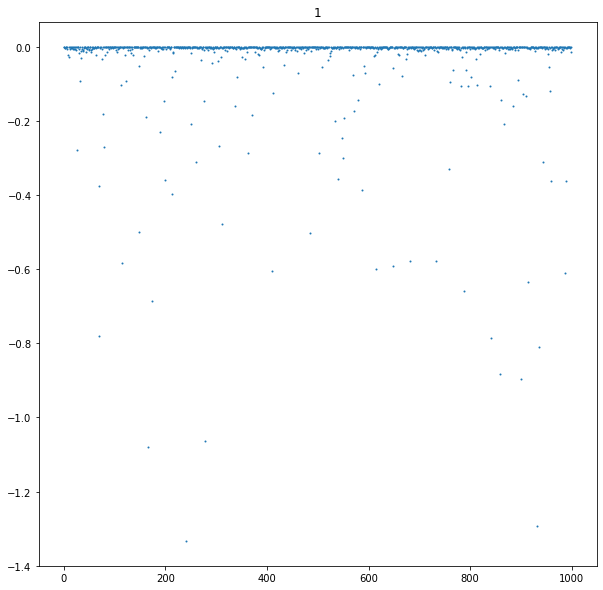

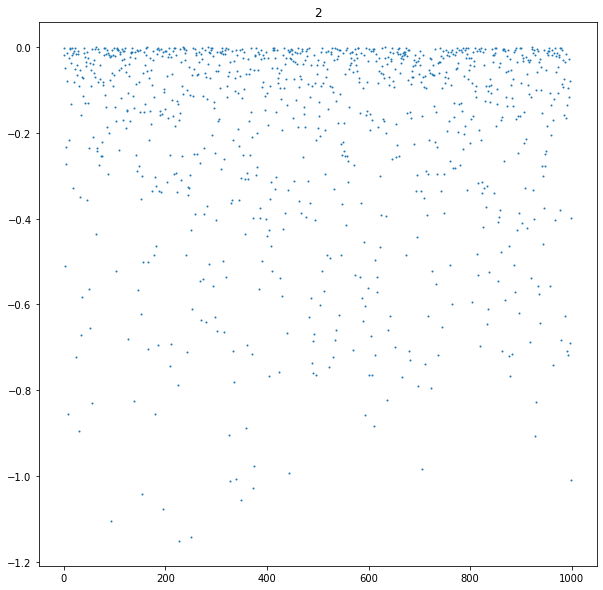

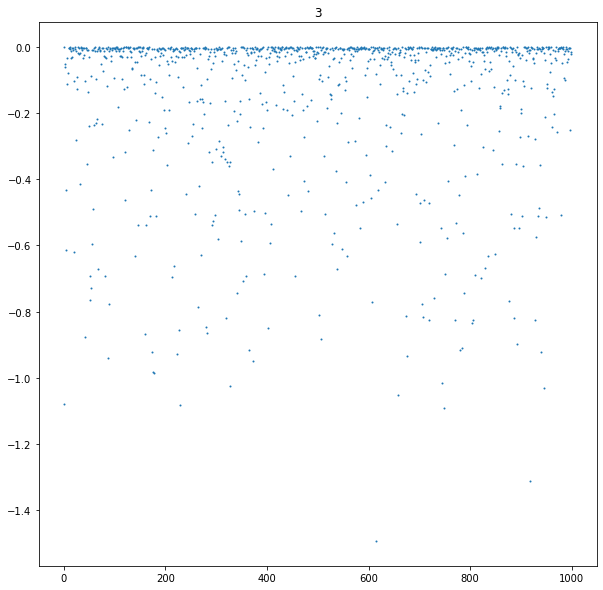

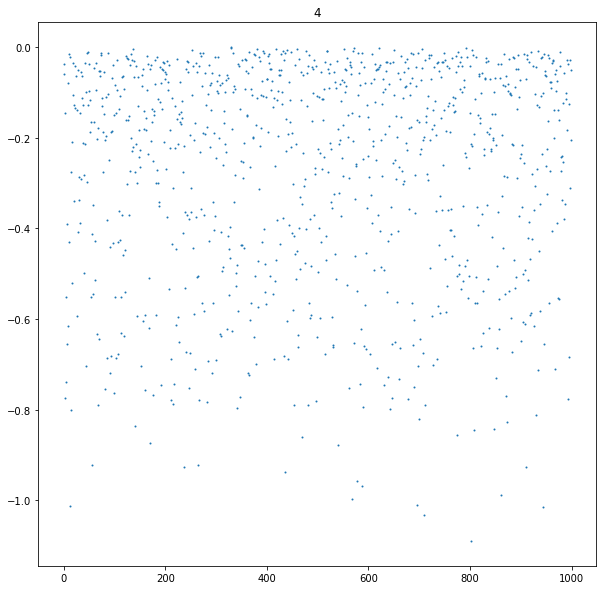

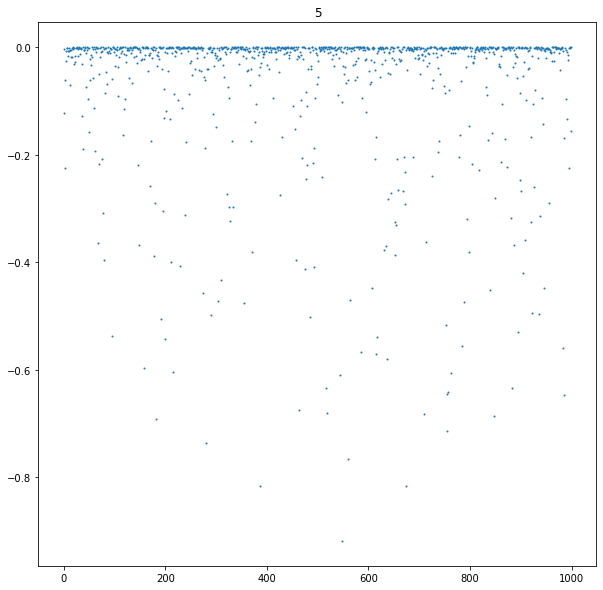

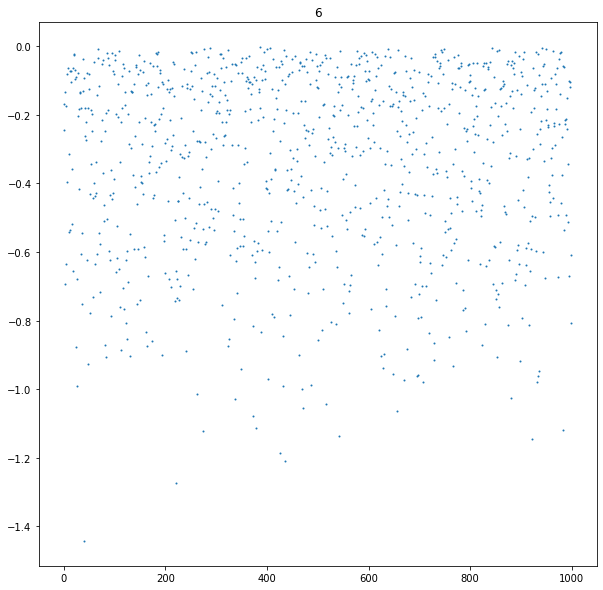

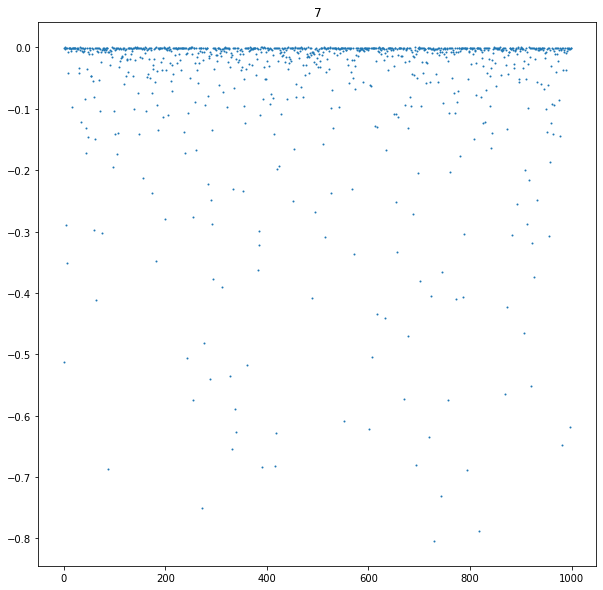

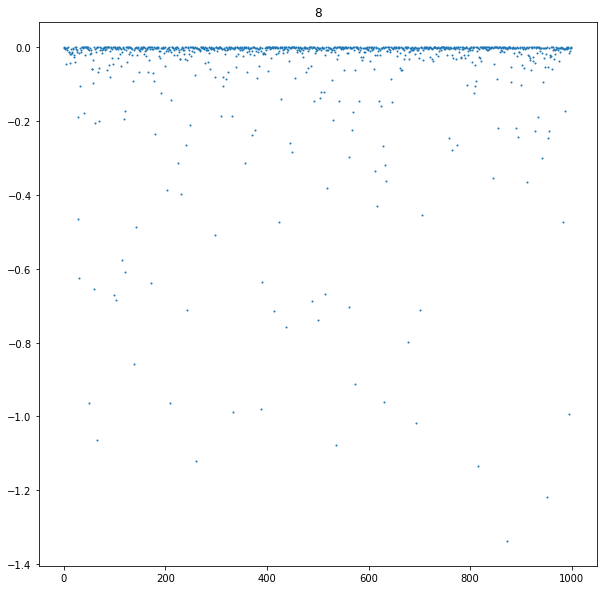

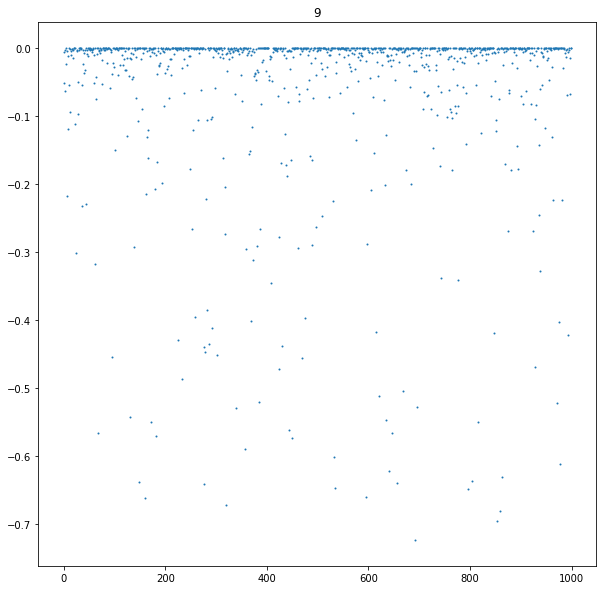

In [22]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure(figsize=(10,10))
    plt.scatter(range(len(scores1[labels1 == i])), scores1[labels1 == i], s=1)
    plt.title(str(i))
    plt.show()

In [ ]:
class Scrambler(object):
    """Randomly swap the locations of mu percent of all pixels in the image."""
    def __init__(self, mu):
        super().__init__()
        self.mu = mu
    
    def __call__(self, image):
        orig_shape = image.shape
        
        # Flatten pixels
        image = image.view(orig_shape[0], -1)
        
        total_pixels = image.shape[1]
        
        # Shuffle mu percent of all pixels by swapping locations
        shuffle = torch.randperm(total_pixels)
        num_to_shuffle = self.mu * total_pixels
        num_to_shuffle -= num_to_shuffle % 2 # Make even number
        shuffle = shuffle[:int(num_to_shuffle)]
        
        ii = torch.arange(start=0, end=total_pixels).int()
        ii[shuffle[0::2]] = shuffle[1::2].int()
        ii[shuffle[1::2]] = shuffle[::2].int()
#         ii[shuffle] = torch.zeros_like(shuffle).int()
    
        image = image[:,ii.long()]
        return image.view(*orig_shape)

scrambler = Scrambler(0.7)
mnist_train_llr_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tadenoud/DATADisk/datasets/', train=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(scrambler),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
def print_dataloader_imgs(dataloader, num=5):
    for x,y in dataloader:
        imgs = x.cpu().numpy()
        for i in range(num):
            plt.imshow(imgs[i].squeeze())
            plt.show()
        break
        
print_dataloader_imgs(mnist_train_llr_loader)

In [ ]:
model2 = Net().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model2, device, mnist_train_llr_loader, optimizer, epoch)
    test(model2, device, mnist_test_loader)

In [ ]:
bind_method(model2, penultimate_forward)
outputs2, features2, labels2 = extract_features(model2, device, train_loader)
class_means2, precision2, _ = estimate_mahalanobis_parameters(features2, labels2, return_tensor=True)

In [ ]:
def mahalanobis_llr_distance(features1, features2, means1, means2, inv_mahal_cov1, inv_mahal_cov2, device):   
    assert(features1.shape[1] == features2.shape[1]) 
    assert(features1.shape[0] == features2.shape[0]) 
    assert(means1.shape[0] == means2.shape[0]) 
    
    # Tile the features and means to vectorize the operation
    num_means = means1.shape[0]
    num_feats = features1.shape[0]

    features1 = features1.repeat(1, num_means).view(-1, features1.shape[1])
    features2 = features2.repeat(1, num_means).view(-1, features2.shape[1])

    # subtract means in batches
    x1 = features1 - means1.repeat(num_feats, 1)
    x2 = features2 - means2.repeat(num_feats, 1)

    # matmul, take diagonal, then reshape
    dists1 = x1.mm(inv_mahal_cov1).mm(x1.transpose(0,1)).diag()
    dists1 = dists1.view(num_feats, num_means)
    dists2 = x2.mm(inv_mahal_cov2).mm(x2.transpose(0,1)).diag()
    dists2 = dists2.view(num_feats, num_means)

    min_dists, labels = dists1.min(dim=1)
    for i, l in enumerate(labels):
        min_dists[i] -= dists2[i][l]
    
    return labels, min_dists


def get_mahalanobis_llr_distances(model1, model2, means1, means2, precision1, precision2, 
                                  device, id_loader, ood_loader):
    model.eval()
    min_dists = []
    labels = []

    with torch.no_grad():
        for data, target in tqdm(id_loader, total=len(id_loader)):
            data, target = data.to(device), target.to(device)
            _, features1 = model1.penultimate_forward(data)
            _, features2 = model2.penultimate_forward(data)
            pred, min_dist = mahalanobis_llr_distance(features1, features2, means1, means2, precision1, 
                                                      precision2, device)
            min_dists.append(min_dist.detach().cpu().numpy())
            labels.append(target.detach().cpu().numpy())
            
        for data, target in tqdm(ood_loader, total=len(ood_loader)):
            data, target = data.to(device), target.to(device)
            _, features1 = model1.penultimate_forward(data)
            _, features2 = model2.penultimate_forward(data)
            pred, min_dist = mahalanobis_llr_distance(features1, features2, means1, means2, precision1, 
                                                      precision2, device) 
            min_dists.append(min_dist.detach().cpu().numpy())
            labels.append(np.ones(len(target)) * -1)
            
    return np.concatenate(min_dists), np.concatenate(labels)

In [ ]:
scores, labels = get_max_softmax_scores(model, device, id_test_loader, ood_test_loader)
temp_labels = labels.copy()
temp_labels[temp_labels >= 0] = 0
temp_labels[temp_labels < 0] = 1
plot_roc(-scores, temp_labels, title="Max Softmax")

scores, labels = get_mahalanobis_distances(model, class_means1, precision1, device, 
                                           id_test_loader, ood_test_loader)
plot_roc(scores, temp_labels, title="Mahalanobis")

scores, labels = get_mahalanobis_distances(model, class_means1, precision1, device, 
                                           id_test_loader, ood_test_loader, epsilon=0.005)
plot_roc(scores, temp_labels, title="Mahalanobis")

scores, _ = get_mahalanobis_llr_distances(model, model2, class_means1, class_means2, precision1, precision2, 
                                          device, id_test_loader, ood_test_loader)
plot_roc(abs(scores), temp_labels, title="LLR")

In [ ]:
plt.scatter(range(len(scores)), abs(scores))
plt.show()

## Buus hard dataset

In [ ]:
import h5py
from torch.utils.data import Dataset, TensorDataset

with h5py.File("/media/tadenoud/DATADisk/datasets/mixed_digits.hdf5", 'r') as f:
    hard_data = f['test_data'][()]

tensor_x = torch.from_numpy(hard_data).permute(0,3,1,2).float()
tensor_y = torch.ones(len(tensor_x)) * -1

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]
        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

hard_dataset = CustomTensorDataset((tensor_x,tensor_y), 
                                   transform=transforms.Normalize((0.1307,), (0.3081,)))
hard_dataloader = torch.utils.data.DataLoader(hard_dataset, batch_size=test_batch_size, shuffle=False)

In [ ]:
scores, labels = get_max_softmax_scores(model, device, id_test_loader, hard_dataloader)
temp_labels = labels.copy()
temp_labels[temp_labels >= 0] = 0
temp_labels[temp_labels < 0] = 1
plot_roc(-scores, temp_labels, title="Max Softmax")

scores, labels = get_mahalanobis_distances(model, class_means1, precision1, device, 
                                           id_test_loader, hard_dataloader)
plot_roc(scores, temp_labels, title="Mahalanobis")

scores, _ = get_mahalanobis_llr_distances(model, model2, class_means1, class_means2, precision1, precision2, 
                                          device, id_test_loader, hard_dataloader)
plot_roc(abs(scores), temp_labels, title="LLR")

# Test Gaussian Assumption

In [ ]:
from scipy import stats

outputs, features, labels = extract_features(model, device, train_loader)
class_means, precision, covariance = estimate_mahalanobis_parameters(features, labels)

In [ ]:
for label in range(num_classes):
    print("LABEL:", label)
    means = class_means[label]
    feats = features[labels == label]
    
    for f in range(feats.shape[1]):
        mean = means[f]
        stdev = np.sqrt(covariance.diagonal()[f])

        ks = stats.kstest(rvs=feats[:,f], cdf="norm", args=(mean, stdev))
        print("i:", f, "pvalue:", ks.pvalue, "statistic:", ks.statistic)